In [3]:
from DataProcess.utils.filehelper import read_csv_file
from tqdm import tqdm
import csv

goods_same = read_csv_file('./data/goods_same.csv')[1:]
goods_similar = read_csv_file('./data/goods_similar_correct.csv')[1:]

1233383it [00:03, 396392.31it/s]
104171it [00:00, 328142.61it/s]


In [9]:
from DataProcess.utils.filehelper import join_prompt_strings
# 有422个长度超过256

final_data = []
max_length = 0
num_max_length = 0
now_str = ''
id = 0

for data in tqdm(goods_similar):
    if len(data)==7:
        if data[5] == 1:
            pass
        else:
            now_str = join_prompt_strings(prompt="对比相同和相似物资:",str_a = data[3],str_b = data[4])
            if len(now_str)>256:
                num_max_length+=1
            if len(now_str)>max_length:
                max_length = len(now_str)
            else:
                final_data.append([id, now_str,data[5],data[6]])
                id += 1

for data in tqdm(goods_same):
    if len(data) == 4:
        now_str = join_prompt_strings(prompt="对比相同和相似物资:",str_a = data[0],str_b = data[1])
        if len(now_str)>256:
                num_max_length+=1
        if len(now_str)>max_length:
            max_length = len(now_str)
        else:
            final_data.append([id,now_str,data[2],data[3]])
            id += 1
print(num_max_length)

100%|██████████| 1233382/1233382 [00:04<00:00, 265237.95it/s]

422


In [16]:
from sklearn.model_selection import train_test_split

def split_data(data_list, test_size=0.1,stratify=False, random_state=42):
    X = [data[0:2] for data in data_list]
    y = [data[2:] for data in data_list]
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    train_list = [x + list(y) for x, y in zip(X_train, y_train)]
    test_list = [x + list(y) for x, y in zip(X_test, y_test)]
    return train_list, test_list

def export_to_csv(data_list, csv_path):
    with open(csv_path, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['id','data', 'same', 'similar'])  # 表头
        for i, data in enumerate(data_list):
            writer.writerow(data)

train_data, test_data  =  split_data(final_data, test_size=0.1,stratify=True, random_state=114514)

NameError: name 'final_data' is not defined

In [11]:
export_to_csv(train_data,'./processed/train.csv')
export_to_csv(test_data, './processed/test.csv')

# 抽取部分数据出来人工矫正

In [1]:
# 人工矫正后数据作为参考,调整模型的阈值
from DataProcess.utils.filehelper import read_csv_file
from tqdm import tqdm
import csv

goods_test = read_csv_file('./processed/test.csv')[1:]


133751it [00:00, 351907.32it/s]


In [17]:
import random
def export_to_csv(data_list, csv_path):
    with open(csv_path, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['id','data', 'same', 'similar'])  # 表头
        for i, data in enumerate(data_list):
            writer.writerow(data)

def extract_balanced_items(items,required_each_count=100):
    # Step 3: Select items
    selected_items = []
    items_00 = []
    items_01 = []
    items_11 = []
    for item in tqdm(items):
        if int(item[2])==0 and int(item[3])==0:
            items_00.append(item)
        if int(item[2])==0 and int(item[3])==1:
            items_01.append(item)
        if int(item[2])==1 and int(item[3])==1:
            items_11.append(item)
    if required_each_count>=len(items):
        return items
    else:
        selected_items.extend(random.sample(items_00, required_each_count))
        selected_items.extend(random.sample(items_01, required_each_count))
        selected_items.extend(random.sample(items_11, required_each_count))
    return selected_items


select_test = extract_balanced_items(goods_test,200)

100%|██████████| 133750/133750 [00:00<00:00, 980973.19it/s]


In [21]:
from operator import itemgetter
processed_data_sorted = sorted(select_test,key=itemgetter(2), reverse=True)
export_to_csv(processed_data_sorted,'./processed/test_sample.csv')
export_to_csv(processed_data_sorted,'./processed/test_sample_correct.csv')

# 对人工矫正后的数据数据分析对比

In [11]:
# 物资a,物资b,拼接后字符,标注标签相同,标注标签相似,矫正标签相同,矫正标签相似,预测标签相同概率,预测标签相似概率,之前的预测标签不相同概率,预测标签相同概率

from utils.filehelper import read_csv_file

test_sample = read_csv_file('./processed/test_sample.csv')[1:]
test_sample_correct = read_csv_file('./processed/test_sample_correct.csv')[1:]


601it [00:00, 244427.10it/s]
601it [00:00, 342217.85it/s]


In [12]:
import json
import requests
from tqdm import tqdm
####################
url_predict_new = 'http://10.100.2.15:8000/predict'
new_headers = {
    "Content-Type": "application/json",
    "apikey": "123456"
}

old_headers = {
    "Content-Type": "application/json",
}

####################
url_predict_old = "http://10.100.2.15:8081/goods/similar/predict"
# 定义要发送的数据
data_new = {
    "goods_a": "商品描述A",
    "goods_b": "商品描述B"
}

# 定义要发送的数据
data_old = {
    "text":"株洲钻石车刀片WNMG080412-DMYBC252适合碳钢半精加工10片/盒,株洲钻石车刀片TNMG160408-EFYBG205适合碳钢、不锈钢精加工10片/盒",
    "category":"common_classification"
}
###################
goods_statistics = []
for s,sc in tqdm(zip(test_sample,test_sample_correct)):
    goods_row = []
    goods_name = s[1].replace('对比相同和相似物资:','')
    goods_a = goods_name.split(',')[0]
    goods_b = goods_name.split(',')[1]
    data_new["goods_a"] = goods_a
    data_new["goods_b"] = goods_b
    data_old["text"] = goods_name
    response_new = json.loads(requests.post(url_predict_new, json=data_new,headers=new_headers).content)
    response_old = json.loads(requests.post(url_predict_old, json=data_old,headers=new_headers).content)
    goods_row = [goods_a,goods_b,goods_name,
                 s[2],s[3],
                 sc[2],sc[3],
                 response_new["same_prob"],response_new["similar_prob"],
                 response_old["content"][0]['0'],response_old["content"][0]['1']
                 ]
    goods_statistics.append(goods_row)

600it [00:48, 12.48it/s]


In [13]:
# 导出数据分析
import csv
def export_to_csv(data_list, csv_path):
    with open(csv_path, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['goods_a','goods_b', 'goods_text', 
                         'goods_same','goods_similar',
                         'goods_same_correct','goods_similar_correct',
                         'same_prob','similar_prob',
                         'old_not_same_prob','old_same_prob'])  # 表头
        for i, data in enumerate(data_list):
            writer.writerow(data)

export_to_csv(goods_statistics,'./processed/goods_statistics.csv')

# 数据统计分析

In [14]:
from utils.filehelper import read_csv_file

goods_statistics = read_csv_file('./processed/goods_statistics.csv')

601it [00:00, 90182.34it/s]


In [77]:
def compute_acc(data,output_col,target_col,threshold=0.5,reverse=False):
    """
    Compute accuracy, precision, recall and f1 score.
    """
    correct = 0
    tp = 0  # True positives 
    tn = 0  # True negatives
    fp = 0  # False positives 
    fn = 0  # False negatives
    num = len(data)-1
    for i in range(num):
        output = float(data[i+1][output_col])
        if output>threshold:
            output = 1
        else:
            output = 0
        target = float(data[i+1][target_col])
        if reverse:
            output = 1-output
        if output == 1 and target ==1:
            tp+=1
        elif output ==0 and target == 0:
            tn +=1
        elif output == 1 and target ==0:
            fp+=1
        elif output == 0 and target == 1:
            fn += 1
    acc = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*(precision*recall)/(precision+recall)
    return acc, precision, recall, f1_score

## GPT 标注准确性

In [78]:
print(f"GPT goods same Acc: {compute_acc(goods_statistics,3,5)} %")
print(f"GPT goods similar Acc: {compute_acc(goods_statistics,4,6)} %")

GPT goods same Acc: (0.9883333333333333, 1.0, 0.966183574879227, 0.9828009828009828) %
GPT goods similar Acc: (0.76, 0.9175, 0.7677824267782427, 0.835990888382688) %


In [79]:
def plot_threshold_analysis(data, output_col=10, target_col=5,title='',reverse=False):
    """
    Plot accuracy, precision, recall and f1 score vs threshold.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    thresholds = np.arange(0.1,1.0,0.01)
    acc, precision, recall, f1_score = [], [], [], []
    for threshold in thresholds:
        data = compute_acc(goods_statistics,output_col,target_col,threshold=threshold,reverse=reverse)
        acc.append(data[0])
        precision.append(data[1])
        recall.append(data[2])
        f1_score.append(data[3])

    plt.plot(thresholds,np.array(acc),label='Accuracy')
    plt.plot(thresholds,np.array(precision),label='Precision')
    plt.plot(thresholds,np.array(recall),label='Recall')
    plt.plot(thresholds,np.array(f1_score),label='F1 Score')
    plt.title(title)
    plt.xlabel('threshold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    

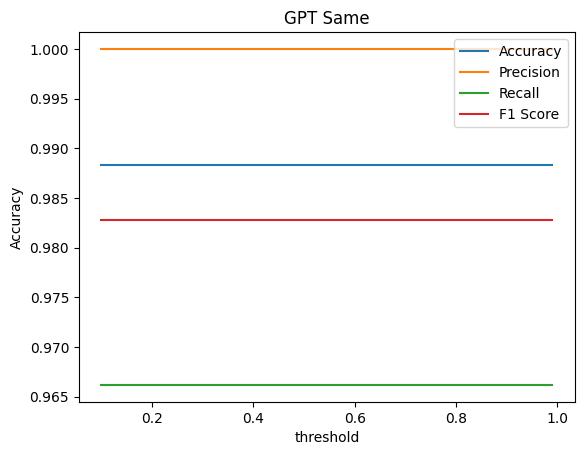

In [80]:
plot_threshold_analysis(data, output_col=3, target_col=5,title='GPT Same')

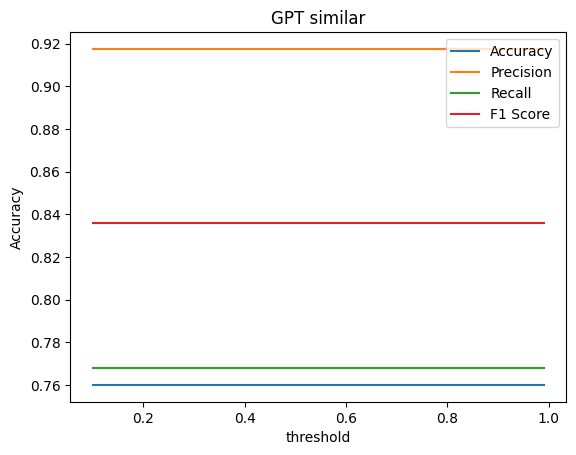

In [81]:
plot_threshold_analysis(data, output_col=4, target_col=6,title='GPT similar')

## 旧的方法预测准确性

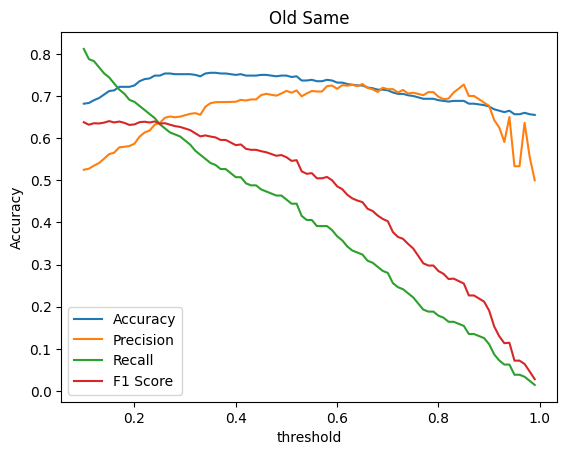

In [82]:
plot_threshold_analysis(goods_statistics, 10, 5,"Old Same")

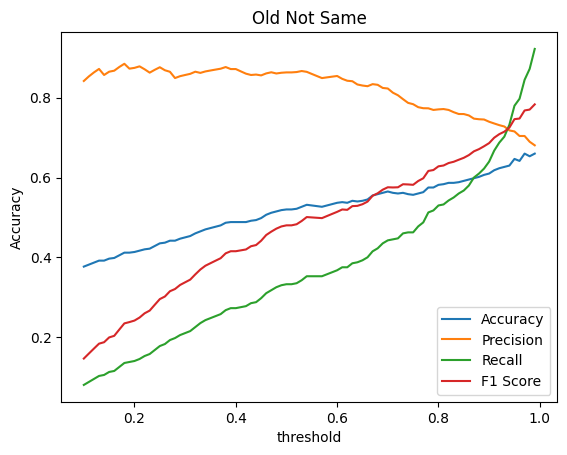

In [83]:
plot_threshold_analysis(goods_statistics, 9, 4,"Old Not Same",reverse=True)

## 新的方法准确率

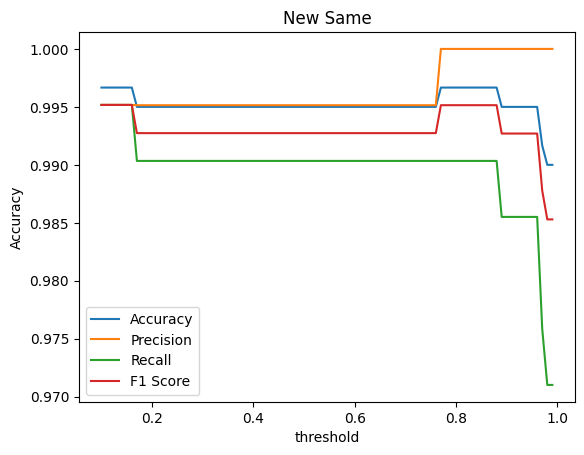

In [72]:
plot_threshold_analysis(goods_statistics, 7, 5,"New Same")

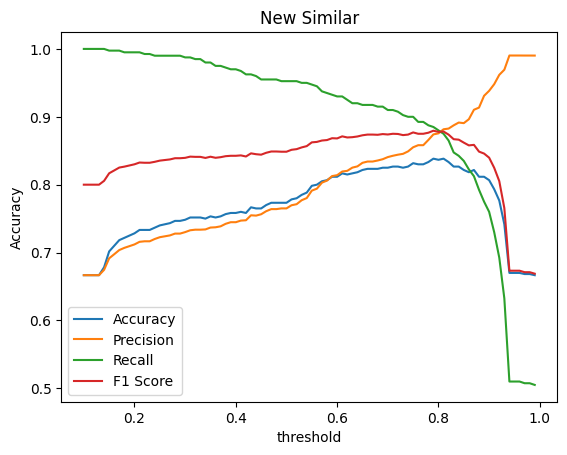

In [71]:
plot_threshold_analysis(goods_statistics, 8, 4,"New Similar")

## 提升

In [91]:
old_acc,old_pre, old_recall, old_f1_score=compute_acc(goods_statistics,10,5,threshold=0.7)
new_acc_same,new_pre_same, new_recall_same, new_f1_score_same = compute_acc(goods_statistics,7,5,threshold=0.8)
print("Same Accuracy:",new_acc_same)
print("Same Precision:",new_pre_same)
print("Same Recall:",new_recall_same)
print("Same F1 Score:",new_f1_score_same)

print("Improved Performance Accuracy:",new_acc_same-old_acc)
print("Improved Performance Precision:",new_pre_same-old_pre)
print("Improved Performance Recall:",new_recall_same-old_recall)
print("Improved Performance F1 Score:",new_f1_score_same-old_f1_score)

Same Accuracy: 0.9966666666666667
Same Precision: 1.0
Same Recall: 0.9903381642512077
Same F1 Score: 0.9951456310679612
Improved Performance Accuracy: 0.2833333333333333
Improved Performance Precision: 0.28395061728395066
Improved Performance Recall: 0.7101449275362318
Improved Performance F1 Score: 0.5923678532901834


In [88]:
new_acc_similar,new_pre_similar, new_recall_similar, new_f1_similar = compute_acc(goods_statistics,8,4,threshold=0.8)

print("Similar Accuracy:",new_acc_similar)
print("Similar Precision:",new_pre_similar)
print("Similar Recall:",new_recall_similar)
print("Similar F1 Score:",new_f1_similar)

Similar Accuracy: 0.8366666666666667
Similar Precision: 0.8756218905472637
Similar Recall: 0.88
Similar F1 Score: 0.8778054862842893


# Predict

In [1]:
from pybert.model.bert_for_multi_label import BertForMultiLable
import torch
from transformers import BertTokenizer
from services.predict import data_predict

# 获取当前可用的CUDA设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForMultiLable.from_pretrained('T:\WorkSpace\\NLP\Bert-Multi-Label-Text-Classification\pybert\output\checkpoints\\bert', num_labels=2).to(device)

tokenizer = BertTokenizer('T:\WorkSpace\\NLP\Bert-Multi-Label-Text-Classification\pybert\pretrain\\bert\\bert-uncased\\vocab.txt', True)

E:\Anaconda\envs\Bert-Classification\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
examples, predict_result = data_predict(str_a='FORANT笔式pH测试仪871174370~14pH1台',
        str_b='BANTE/般特六合一水质检测仪M852-1~15pH1台',
        model=model,tokenizer=tokenizer,
        max_seq_len=512,example_type='predict',device=device)
print(predict_result)

tensor([[0.0160, 0.5531]], device='cuda:0')


In [3]:
from tqdm import tqdm

num_times = 1000

s = 's'
for i in tqdm(range(num_times)):
    # 发送POST请求并获取响应
   examples, predict_result = data_predict(str_a='FORANT笔式pH测试仪871174370~14pH1台'+i*s,
        str_b='BANTE/般特六合一水质检测仪M852-1~15pH1台',
        model=model,tokenizer=tokenizer,
        max_seq_len=512,example_type='predict',device=device)

100%|██████████| 1000/1000 [00:14<00:00, 67.82it/s]


In [10]:
import requests
from tqdm import tqdm

num_times = 1000
# 修改为您的API地址，如果在本地运行，可以使用 http://127.0.0.1:8000/predict
url = "http://localhost:8000/predict"

headers = {
    "Content-Type": "application/json",
    "apikey": "123456"   
}

# 定义要发送的数据
data = {
    "goods_a": "商品描述A",
    "goods_b": "商品描述B"
}

for i in tqdm(range(num_times)):
    # 发送POST请求并获取响应
    response = requests.post(url, json=data,headers=headers)

100%|██████████| 1000/1000 [00:16<00:00, 61.77it/s]


In [ ]:
url = "http://10.100.2.15:8081/goods/similar/predict"

headers = {
    "Content-Type": "application/json",
}

# 定义要发送的数据
data = {
    "text":"株洲钻石车刀片WNMG080412-DMYBC252适合碳钢半精加工10片/盒,株洲钻石车刀片TNMG160408-EFYBG205适合碳钢、不锈钢精加工10片/盒",
    "category":"common_classification"
}

for i in tqdm(range(num_times)):
    # 发送POST请求并获取响应
    response = requests.post(url, json=data,headers=headers)

In [8]:
print(response.content)

b'{\n  "charset": "utf-8", \n  "content": [\n    {\n      "0": 0.9826, \n      "1": 0.02057\n    }\n  ], \n  "content_type": "application/json;charset=utf-8", \n  "reason": "success", \n  "status": "200"\n}\n'


# 阈值选择与统计